# 1.2 
## Natural Language Processing / Amazon Reviews

Reusable function for text processing.

Finding
Cannot reject null hypothesis.
Model has high accuracy for predicting positives. Poor accuracy for negatives due to proportion in dataset.

In [53]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()

import re
from nltk.util import ngrams

[nltk_data] Downloading package punkt to /Users/denise/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/denise/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
#https://towardsdatascience.com/a-gentle-introduction-to-natural-language-processing-e716ed3c0863
def processed_ngrams(review):
    
    #cleaning html tags and words
    review = re.sub(re.compile('<.*?>'), '', review)
    review = re.sub('[^A-Za-z0-9]+', ' ', review)
    
    #lowercase
    review = review.lower()
    #tokenization
    tokens = nltk.word_tokenize(review)
    #remove stopwords
    review = [word for word in tokens if word not in stop_words]
    #lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
    #
    review = ' '.join(review)
    
    return review


In [55]:
df = pd.read_csv("data/amazon_alexa.tsv", sep="\t")

In [56]:
df.columns = ['rating', 'date', 'variation', 'review', 'feedback']

df['processed_ngrams'] = df['review'].apply(lambda review: processed_ngrams(review))
df.head()

,rating,date,variation,review,feedback,processed_ngrams
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,loved
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,sometimes playing game answer question correct...
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learns dinosaur control...
4,5,31-Jul-18,Charcoal Fabric,Music,1,music


rating              0
date                0
variation           0
review              0
feedback            0
processed_ngrams    0
dtype: int64

In [57]:
from sklearn.model_selection import train_test_split
data = df.copy()
y = data['feedback'].values
data.drop(['feedback'], axis = 1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)
print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)

Train data: (2205, 5) (2205,)
Test data: (945, 5) (945,)


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=10,ngram_range=(1, 2))

x_train_review_bow = vect.fit_transform(x_train['processed_ngrams'])
x_test_review_bow = vect.transform(x_test['processed_ngrams'])

print('x_train_review_bow shape: ', x_train_review_bow.shape)
print('x_test_review_bow shape: ', x_test_review_bow.shape)

x_train_review_bow shape:  (2205, 602)
x_test_review_bow shape:  (945, 602)


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2))

x_train_review_tfidf = vectorizer.fit_transform(x_train['processed_ngrams'])
x_test_review_tfidf = vectorizer.transform(x_test['processed_ngrams'])
print('x_train_review_tfidf shape: ', x_train_review_tfidf.shape)
print('x_test_review_tfidf shape: ', x_test_review_tfidf.shape)

x_train_review_tfidf shape:  (2205, 602)
x_test_review_tfidf shape:  (945, 602)


In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(x_train_review_bow, y_train)
y_pred = clf.predict(x_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.9185185185185185


In [65]:
clf = MultinomialNB(alpha=1)
clf.fit(x_train_review_tfidf, y_train)

y_pred = clf.predict(x_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.9185185185185185


In [66]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1')
clf.fit(x_train_review_tfidf, y_train)

y_pred = clf.predict(x_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.9206349206349206


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


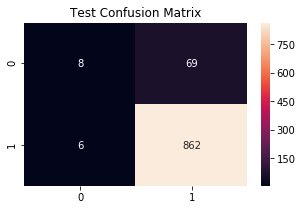

In [68]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()